In [50]:
import json
import torch
from textwrap import shorten
from sentence_transformers import SentenceTransformer
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree, to_undirected
from pyvis.network import Network
import matplotlib.colors as mcolors
import matplotlib.cm as cm

DATASET_PATH = "../data/wiki_graph_restored_knn.json"

### Let's load the dataset after all the filtering steps

In [3]:
dataset_json = json.loads(open(DATASET_PATH, "r").read())

In [15]:
nodes_dict = dataset_json['nodes']
edges_list = dataset_json['edges']

titles = list(nodes_dict.keys())
title_to_idx = {title: i for i, title in enumerate(titles)}

categories = set(d['category'] for d in nodes_dict.values())
cat_to_idx = {cat: i for i, cat in enumerate(categories)}

print(f"Nodes: {len(titles)}, Classes: {len(categories)}")

Nodes: 6093, Classes: 8


### Prepare `edge_index` for PyG library

In [32]:
y = torch.tensor([cat_to_idx[nodes_dict[t]['category']] for t in titles], dtype=torch.long)

# [2, num_edges]
edge_indices = []
self_loops_count = 0

for src, dst in edges_list:
    if src in title_to_idx and dst in title_to_idx and src != dst:
        edge_indices.append([title_to_idx[src], title_to_idx[dst]])
    
    elif src == dst:
        self_loops_count += 1

print(f"Filtered out {self_loops_count} self-loops.")


edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
edge_index = to_undirected(edge_index)

Filtered out 37 self-loops.


In [33]:
edge_index.size()

torch.Size([2, 56470])

### Prepare node features

In [22]:
model_name: str = "google/embeddinggemma-300m"
device: str = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"[INFO] Loading embedding model: {model_name} on {device}")

model = SentenceTransformer(model_name, device=device, truncate_dim=384)

query_prompts = [shorten(nodes_dict[t].get("text", ""), width=750) for t in titles]

print(f"[INFO] Generating embeddings for {len(query_prompts)} nodes...")

query_embeddings = model.encode(
    query_prompts,
    batch_size=8,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,
)

print(f"[INFO] Generated embeddings shape: {query_embeddings.shape}")

x = torch.tensor(query_embeddings, dtype=torch.float)

[INFO] Loading embedding model: google/embeddinggemma-300m on mps


You are trying to use a model that was created with Sentence Transformers version 5.1.0, but you're currently using version 4.1.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.


[INFO] Generating embeddings for 6093 nodes...


Batches:   0%|          | 0/762 [00:00<?, ?it/s]

[INFO] Generated embeddings shape: (6093, 384)


### Wrap up the dataset with Data class from PyG

In [36]:
data = Data(x=x, edge_index=edge_index, y=y)

In [54]:
# Save dataset for future use
torch.save(data, "../data/wiki_it_graph.pt")

### Now let's explore the dataset we have

Graph Statistics:
Number of nodes: 6093
Number of edges (undirected): 28235
PyG internal edges (total message paths): 56470
Average node degree: 9.27
Min degree: 3.0
Max degree: 93.0
Median degree: 9.0
Number of classes: 8
Has isolated nodes: False
Has self-loops: False
Is undirected: True


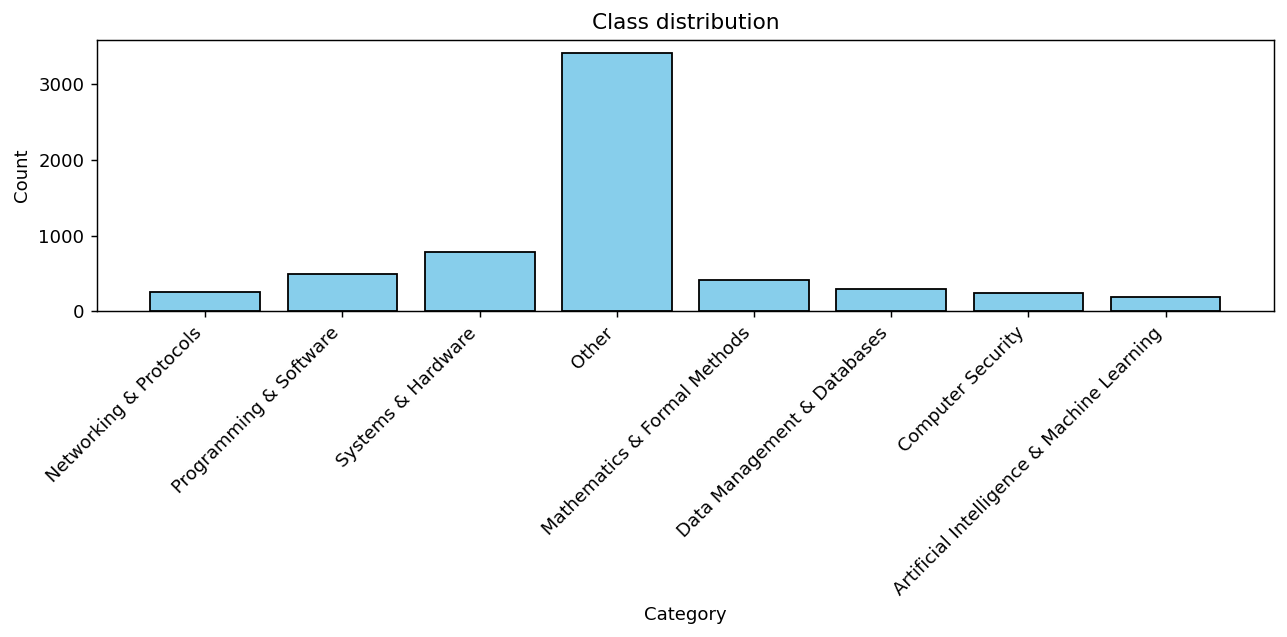

In [45]:
def print_graph_stats(data):
    print("=" * 30)
    print(f"Graph Statistics:")
    print(f"Number of nodes: {data.num_nodes}")

    real_num_edges = data.num_edges / 2
    avg_degree = data.num_edges / data.num_nodes
    print(f"Number of edges (undirected): {int(real_num_edges)}")
    print(f"PyG internal edges (total message paths): {data.num_edges}")
    print(f"Average node degree: {avg_degree:.2f}")

    # Min/Max Degree
    d = degree(data.edge_index[1], num_nodes=data.num_nodes)
    print(f"Min degree: {d.min().item()}")
    print(f"Max degree: {d.max().item()}")

    print(f"Median degree: {d.median().item()}")
    print(f"Number of classes: {len(torch.unique(data.y))}")
    print(f"Has isolated nodes: {data.has_isolated_nodes()}")
    print(f"Has self-loops: {data.has_self_loops()}")
    print(f"Is undirected: {data.is_undirected()}")
    print("=" * 30)


print_graph_stats(data)


idx_to_cat = {i: cat for cat, i in cat_to_idx.items()}
unique, counts = torch.unique(data.y, return_counts=True)
class_names = [idx_to_cat[i.item()] for i in unique]

plt.figure(figsize=(10, 5), dpi=130)
plt.bar(unique.numpy(), counts.numpy(), color="skyblue", edgecolor="black")

plt.title("Class distribution")
plt.xlabel("Category")
plt.ylabel("Count")

plt.xticks(ticks=unique.numpy(), labels=class_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()

Converting to NetworkX (6093 nodes)...
Calculating layout...
Drawing...


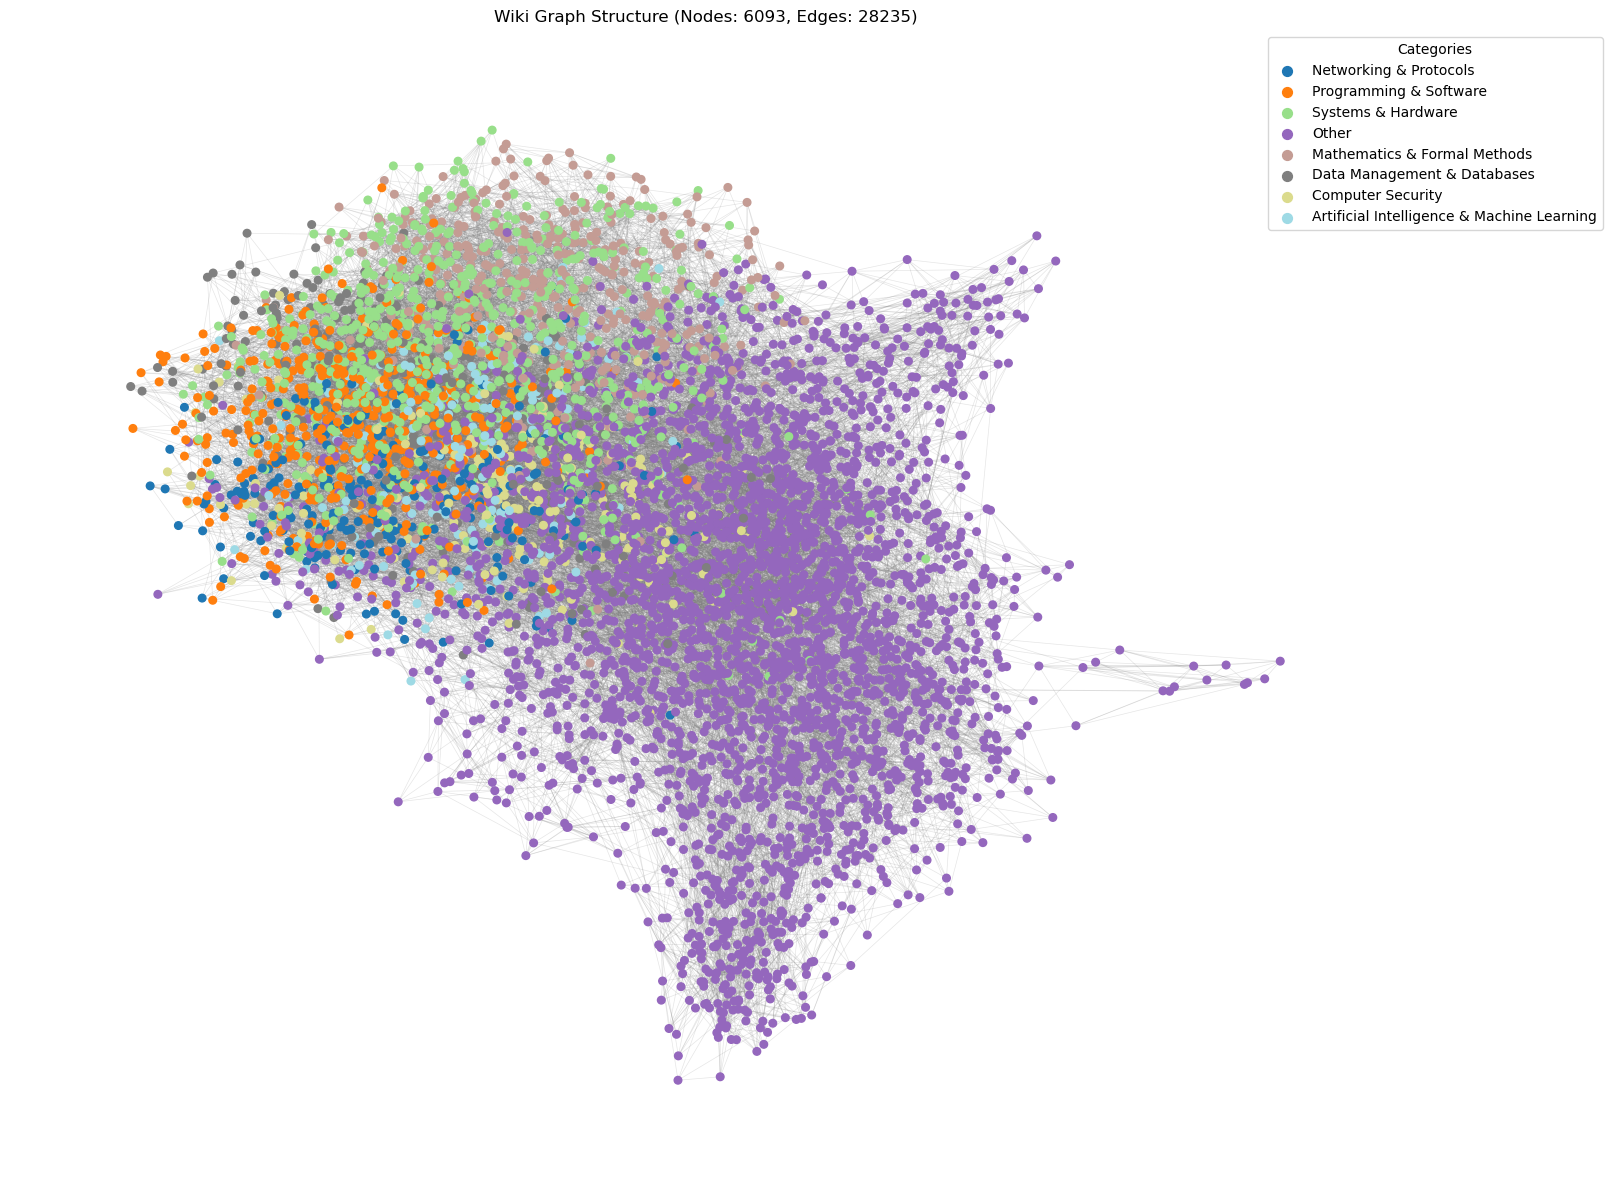

In [52]:
def visualize_static(data, title="Wiki Graph Structure"):
    print(f"Converting to NetworkX ({data.num_nodes} nodes)...")
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(data.edge_index.t().tolist())

    node_labels = data.y.numpy()
    unique_classes = np.unique(node_labels)

    cmap = plt.get_cmap("tab20")

    node_colors = []
    for label in node_labels:
        node_colors.append(cmap(label / max(len(unique_classes) - 1, 1)))

    # Calculate graph layout
    print("Calculating layout...")
    pos = nx.spring_layout(G, seed=42, k=0.15, iterations=50)

    print("Drawing...")
    plt.figure(figsize=(16, 12))

    # Edges
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.2,
        edge_color="gray",
        width=0.5,
    )

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, cmap=cmap)

    # Add legend
    for cls_id in unique_classes:
        plt.scatter(
            [],
            [],
            c=[cmap(cls_id / max(len(unique_classes) - 1, 1))],
            label=idx_to_cat[cls_id],
            s=50,
        )

    plt.legend(loc="upper right", title="Categories", bbox_to_anchor=(1.15, 1))
    plt.title(
        f"{title} (Nodes: {data.num_nodes}, Edges: {data.num_edges // 2 if data.is_undirected() else data.num_edges})"
    )
    plt.axis("off")  # remove x,y axis

    plt.tight_layout()
    plt.savefig("wiki_graph_full.png", dpi=200)
    plt.show()


visualize_static(data)